In [11]:
import os, sys, time
import tifffile as tif
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe")
from tools.utils.io import makedir
from tools.registration.register import change_interpolation_order, transformix_command_line_call
from tools.registration.transform_list_of_points import modify_transform_files
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [230]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"

fann = os.path.join(src,"tiffs/fPRA_to_PRA_net_jacobian.tif")
#fann = os.path.join(src,"output_dirs/SIGMA_in_fPRA/result.tif")
#fann_affine = os.path.join(src, "output_dirs/SIGMA_fPRA_in_PRA_affine/result.tif")
mann = os.path.join(src, "output_dirs/SIGMA_ann_in_PRA_25/result.tif")

#fann = os.path.join(src, "tiffs/WHS_ann_in_fPRA.tif")
#mann = os.path.join(src, "output_dirs/WHS_ann_in_PRA25/WHS_anns_in_PRA25.tif")

#annotationsfilename=os.path.join(src,"labels/labels_v3.csv")

annotationsfilename = os.path.join(src,"labels/SIGMA_good_labels.csv")
output= "/home/emilyjanedennis/Desktop/mf_SIGMA.tiff"
percentcsv="/home/emilyjanedennis/Desktop/mf_percent_SIGMA.csv"

## get percent of each brain for a given 'value' or label

In [231]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1,2],header=0)
print("read annotations")

read annotations


In [232]:
df=anns.dropna()
df


,atlas,ID,label
0,Tohoku,11,Agranular Dysgranular Insular Cortex
1,Tohoku,12,Agranular Dysgranular Insular Cortex
2,Tohoku,21,Agranular Insular Cortex
3,Tohoku,22,Agranular Insular Cortex
4,Tohoku,31,Amygdalohyppocampic Area
...,...,...,...
177,Waxholm,1132,Thalamus
178,Waxholm,1141,Brachium Pontis
179,Waxholm,1142,Brachium Pontis
180,Waxholm,1161,Periventricular Grey


In [233]:
df.insert(3,'fvox',0)
df.insert(4,'fvox_affine',0)
df.insert(5,'mvox',0)


In [234]:
ftiff = tif.imread(fann)
#faffinetiff = tif.imread(fann_affine)
mtiff = tif.imread(mann)
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')

In [235]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])

<ipython-input-235-01c5cdf64e11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.mean(ftiff[SIGMAtiff==i])


In [236]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
fsigmatiff = msigmatiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        fsigmatiff[fsigmatiff==i]=0

0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [237]:
np.max(fsigmatiff)

181

In [238]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() > 0.1:
        print(np.shape(fsigmatiff[fsigmatiff==i]))
        fsigmatiff[fsigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
(54968,)


<ipython-input-238-ae2ce6616ac2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() > 0.1:


1    221
Name: fvox, dtype: int16
(55343,)
2    37
Name: fvox, dtype: int16
(372549,)
3    234
Name: fvox, dtype: int16
(383733,)
4    116
Name: fvox, dtype: int16
(35191,)
5    78
Name: fvox, dtype: int16
(32045,)
6    149
Name: fvox, dtype: int16
(273770,)
7    170
Name: fvox, dtype: int16
(252711,)
8    196
Name: fvox, dtype: int16
(1323564,)
9    210
Name: fvox, dtype: int16
(1365468,)
10    271
Name: fvox, dtype: int16
(44955,)
11    289
Name: fvox, dtype: int16
(45487,)
12    174
Name: fvox, dtype: int16
(503913,)
13    165
Name: fvox, dtype: int16
(484677,)
14    178
Name: fvox, dtype: int16
(80373,)
15    170
Name: fvox, dtype: int16
(77194,)
16    234
Name: fvox, dtype: int16
(463119,)
17    243
Name: fvox, dtype: int16
(437168,)
18    236
Name: fvox, dtype: int16
(711879,)
19    244
Name: fvox, dtype: int16
(676271,)
20    117
Name: fvox, dtype: int16
(84468,)
21    378
Name: fvox, dtype: int16
(80631,)
22    74
Name: fvox, dtype: int16
(206293,)
23    178
Name: fvox, dtype: 

In [239]:
np.max(fsigmatiff)

405

In [240]:
SIGMAtiff = tif.imread('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif')
msigmatiff= SIGMAtiff
np.max(fsigmatiff)

for i in np.unique(SIGMAtiff):
    if i in df['ID']:
        print(i)
    else:
        msigmatiff[msigmatiff==i]=0


0
11
12
21
22
31
32
41
42
51
52
61
62
71
72
81
82
91
92
101
102
111
112
121
122
131
132
141
142
151
152
161
162
171
172
181


In [241]:
for i in df['ID']:
    val = (df.fvox[df.ID==i])*1000
    print(val.astype('int16'))
    if val.item() < 0:
        print(np.shape(msigmatiff[msigmatiff==i]))
        msigmatiff[msigmatiff==i]=val.astype('int16')

0    7
Name: fvox, dtype: int16
1    221
Name: fvox, dtype: int16
2    37
Name: fvox, dtype: int16
3    234
Name: fvox, dtype: int16
4    116
Name: fvox, dtype: int16
5    78
Name: fvox, dtype: int16
6    149
Name: fvox, dtype: int16
7    170
Name: fvox, dtype: int16
8    196
Name: fvox, dtype: int16
9    210
Name: fvox, dtype: int16
10    271
Name: fvox, dtype: int16
11    289
Name: fvox, dtype: int16
12    174
Name: fvox, dtype: int16
13    165
Name: fvox, dtype: int16
14    178
Name: fvox, dtype: int16
15    170
Name: fvox, dtype: int16
16    234
Name: fvox, dtype: int16
17    243
Name: fvox, dtype: int16
18    236
Name: fvox, dtype: int16
19    244
Name: fvox, dtype: int16
20    117
Name: fvox, dtype: int16
21    378
Name: fvox, dtype: int16
22    74
Name: fvox, dtype: int16
23    178
Name: fvox, dtype: int16
24    36
Name: fvox, dtype: int16
25    1
Name: fvox, dtype: int16
26    233
Name: fvox, dtype: int16
27    235
Name: fvox, dtype: int16
28    241
Name: fvox, dtype: int16
29 

<ipython-input-241-21cdfcfacca2>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  if val.item() < 0:


50    132
Name: fvox, dtype: int16
51    70
Name: fvox, dtype: int16
52    200
Name: fvox, dtype: int16
53    195
Name: fvox, dtype: int16
54    185
Name: fvox, dtype: int16
55    116
Name: fvox, dtype: int16
56    188
Name: fvox, dtype: int16
57    131
Name: fvox, dtype: int16
58    100
Name: fvox, dtype: int16
59    379
Name: fvox, dtype: int16
60    137
Name: fvox, dtype: int16
61    55
Name: fvox, dtype: int16
62    110
Name: fvox, dtype: int16
63    55
Name: fvox, dtype: int16
64    13
Name: fvox, dtype: int16
65   -52
Name: fvox, dtype: int16
(0,)
66    89
Name: fvox, dtype: int16
67    16
Name: fvox, dtype: int16
68    252
Name: fvox, dtype: int16
69    257
Name: fvox, dtype: int16
70    120
Name: fvox, dtype: int16
71    61
Name: fvox, dtype: int16
72    98
Name: fvox, dtype: int16
73    10
Name: fvox, dtype: int16
74    103
Name: fvox, dtype: int16
75    34
Name: fvox, dtype: int16
76    181
Name: fvox, dtype: int16
77    164
Name: fvox, dtype: int16
78    113
Name: fvox, dtyp

In [242]:
tif.imsave('/home/emilyjanedennis/Desktop/msigma.tif',msigmatiff)
tif.imsave('/home/emilyjanedennis/Desktop/fsigma.tif',fsigmatiff)

array([], dtype=int16)

In [146]:
print(np.max(SIGMAtiff))
print(np.min(SIGMAtiff))

0
0


In [8]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])
    df.mvox[df.index[df.ID==i]] = np.size(mtiff[mtiff==i])


<ipython-input-8-5162a856bfbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])


In [9]:
df = df[df.fvox > 0]


In [10]:
df

,atlas,ID,label,fvox,fvox_affine,mvox


In [10]:
df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
df['mpct'] = (df['mvox']/np.sum(df.mvox))*100
df['fa_m_over_fam']= (df['fpct_affine']-df['mpct'])/(df['fpct_affine']+df['mpct'])
df['fa_vox_vs_m'] = (df.fvox_affine - df.mvox)/(df.mvox)
df

<ipython-input-10-cd99e5788101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
<ipython-input-10-cd99e5788101>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct_affine'] = (df['fvox_affine']/np.sum(df.fvox_affine))*100
<ipython-input-10-cd99e5788101>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

,atlas,ID,label,fvox,fvox_affine,mvox,fpct,fpct_affine,mpct,fa_m_over_fam,fa_vox_vs_m
1,Waxholm,171,Globus Pallidus,2572,3265,2844,0.004230,0.004364,0.004000,0.043506,0.148031
2,Waxholm,731,Striatum,1466457,1813067,1664466,2.411643,2.423155,2.340903,0.017265,0.089278
3,Waxholm,221,Granule Cell Level of the Cerebellum,1018451,1259382,1265190,1.674881,1.683158,1.779362,-0.027784,-0.004591
4,Waxholm,341,Molecular Layer of the Cerebellum,3429328,4238434,4095170,5.639657,5.664646,5.759442,-0.008298,0.034984
5,Tohoku,31,Amygdalohyppocampic Area,26485,32843,35191,0.043556,0.043895,0.049493,-0.059945,-0.066722
...,...,...,...,...,...,...,...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,2630,3297,2401,0.004325,0.004406,0.003377,0.132293,0.373178
230,Waxholm,902,Deeper Layers of the Superior Colliculus,433198,535986,440010,0.712410,0.716343,0.618829,0.073034,0.218122
231,Waxholm,1082,SP5,24785,30876,29813,0.040760,0.041266,0.041929,-0.007973,0.035656
232,Waxholm,792,Anterior Commissure Intrabulbar part,37530,46420,45913,0.061719,0.062040,0.064572,-0.019997,0.011043


In [11]:
df.to_csv('/home/emilyjanedennis/Desktop/fa_vals.csv')

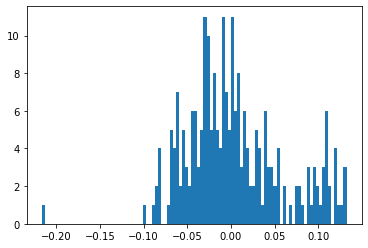

In [13]:
plt.hist(df.fa_m_over_fam,bins=100)
plt.show()

In [70]:
mp = 0
sp = np.nanstd(df.fg)

In [71]:
highmp = mp+sp
highmp
highermp = mp+(2*sp)

In [72]:
lowmp = mp-(0.5*sp)
lowmp
lowermp=mp-(2*sp)

In [17]:
df=pd.read_csv(percentcsv)

In [69]:
mp

-0.0045578046095393135

1162

In [148]:
# want to take IDs and set all to 0 except fg > highmp == 800, fg > higher mp == 1000
# fg < lowmp == 600, fg < lowermp == 500
# then save the tiff
sex_relative = tif.imread(mann)
np.max(sex_relative)

for i in df['ID']:
    if df[df['ID']==i]['fg'].item() >.09:
        sex_relative[sex_relative==i]=1000
    else:
        sex_relative[sex_relative==i]=0

In [149]:
tif.imsave('/home/emilyjanedennis/Desktop/hi_sigma.tif',sex_relative)

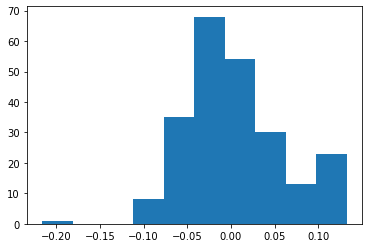

In [104]:
plt.hist(df['fg'])
plt.show()

In [142]:
np.sum(df['fg']<-.06)

24

In [143]:
np.sum(df['fg']>.09)

27

-0.11149420498351735